In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from lazypredict.Supervised import LazyClassifier
# from matplotlib import pyplot
# import matplotlib.pyplot as plt    

# plt.style.use('ggplot')  
# %matplotlib inline

In [3]:
raw_data = pd.read_csv('training_data/bband_training_data_long_31_0520.csv')

In [4]:
raw_data.tail()

,date,side,sma,out,long_ret,short_ret,com_rev,d_yield,pb,AD,...,b_MA60,b_bias5,b_bias10,b_bias20,b_bias60,b_acc5,b_acc10,b_acc20,b_acc60,b_volatility
651424,2019-01-09,0.00,-1.00,-1,-0.01,0.00,-0.01,0.73,-0.08,-0.15,...,-0.06,0.89,0.65,0.35,-0.00,-0.05,-0.13,-0.23,-0.20,0.25
651425,2019-01-10,6.00,-1.00,0,0.02,-0.02,-0.55,0.75,-0.15,-0.15,...,-0.04,0.73,0.58,0.33,-0.02,-0.08,-0.39,-0.04,-0.17,0.17
651426,2019-01-11,1.00,-1.00,0,-0.00,-0.00,-0.55,0.74,-0.15,-0.15,...,-0.15,0.74,0.70,0.47,0.09,-0.43,-0.49,-0.10,-0.25,0.16
651427,2019-01-14,1.00,-1.00,0,0.01,-0.01,-0.55,0.73,-0.08,-0.14,...,-0.09,0.51,0.58,0.38,0.03,-0.12,-0.09,-0.16,-0.21,0.16
651428,2019-01-15,0.00,-1.00,0,0.01,-0.01,-0.55,0.73,-0.08,-0.13,...,-0.19,0.59,0.73,0.50,0.13,-0.32,-0.12,-0.10,-0.27,0.18


In [5]:
# for long dataset out == 1 & side == 1 or -1
# for short dataset out == -1 & side == 1 or -1
training_data = raw_data.copy()
training_data['out'] = training_data['out'].apply(lambda x:1 if x == 1 else 0)
training_data = training_data.sort_values(by=['date'])
training_data['side'] = training_data['side'].apply(lambda x:1 if x == 3 else 0)
# training_data = training_data[training_data.side == 1]
# training_data = training_data[training_data.date > '2020-01-01']
print(f'training_data.shape : {training_data.shape}')

col_list = ['date','side', 'com_rev', 'd_yield', 'pb', 'AD', 'OBV', 'ADOSC', 'bias5',
    'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
    'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility',
    'MA5', 'MA20', 'MA60', 'MACD', 'signal', 'hist',
    'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
    'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'b_OBV', 'b_AD', 'b_ADOSC',
    'b_MA5', 'b_MA20', 'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60',
    'b_acc5', 'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility', 'out']
    
data = training_data[col_list].iloc[:int(training_data.shape[0]*.1),:]
train_data = data.iloc[:int(data.shape[0]*.7),:]
print(train_data.shape)
test_data = data.iloc[int(data.shape[0]*.7):,:]
print(test_data.shape)

training_data.shape : (651429, 59)
(45599, 56)
(19543, 56)


In [6]:
print(f'train_data.date.min {train_data.date.min()}')
print(f'train_data.date.max {train_data.date.max()}')
print(f'train_data.shape {train_data.shape}')
print(f'test_data.date.min {test_data.date.min()}')
print(f'test_data.date.max {test_data.date.max()}')
print(f'test_data.shape {test_data.shape}')

train_data.date.min 2016-12-27
train_data.date.max 2017-03-01
train_data.shape (45599, 56)
test_data.date.min 2017-03-01
test_data.date.max 2017-03-23
test_data.shape (19543, 56)


In [7]:
train_data.out.value_counts()

0    27099
1    18500
Name: out, dtype: int64

In [8]:
def Upsample(df):
    # Separate majority and minority classes
    shape_0 = df[df.out==0].shape[0]
    shape_1 = df[df.out==1].shape[0]
    if shape_0 > shape_1:
        df_majority = df[df.out==0]
        df_minority = df[df.out==1]
        n = 0
    else:
        df_majority = df[df.out==1]
        df_minority = df[df.out==0]   
        n = 1
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df.out.value_counts()[n],    # to match majority class
                                    random_state=123) # reproducible results
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    # Display new class counts
    print(f'before\n {df.out.value_counts()}')
    print(f'after\n {df_upsampled.out.value_counts()}')
    return df_upsampled

train_data_up = Upsample(train_data)
# test_data_up = Upsample(test_data)
# train_data_up = train_data_up.sample(frac=0.9, replace=True, random_state=1)

X = train_data_up.iloc[:,1:-1]
y = train_data_up.iloc[:,-1]
X_test = test_data.iloc[:,1:-1]
y_test = test_data.iloc[:,-1]

before
 0    27099
1    18500
Name: out, dtype: int64
after
 1    27099
0    27099
Name: out, dtype: int64


<AxesSubplot:>

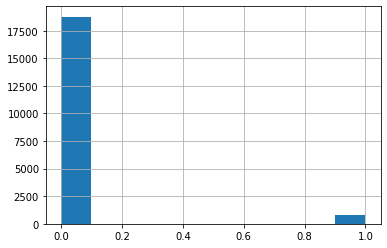

In [9]:
test_data.side.hist()

In [10]:
y.head()

319463    0
319970    0
320477    0
322505    0
323012    0
Name: out, dtype: int64

In [11]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X, X_test, y, y_test)
# models,predictions = clf.fit(X, X_val, y_ train, y_val)

100%|██████████| 29/29 [40:07<00:00, 83.03s/it]   


In [10]:
joblib.dump(models,'lazypredict/models_LGBMClassifier_short_trend .pkl')
joblib.dump(predictions,'lazypredict/predictions_LGBMClassifier_short_trend .pkl')

['lazypredict/predictions_LGBMClassifier_short_trend .pkl']

In [12]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.68,0.58,0.58,0.66,2.10
GaussianNB,0.61,0.58,0.58,0.62,0.30
XGBClassifier,0.68,0.58,0.58,0.66,14.07
NuSVC,0.70,0.57,0.57,0.66,1610.02
QuadraticDiscriminantAnalysis,0.48,0.56,0.56,0.48,0.54
NearestCentroid,0.60,0.56,0.56,0.61,0.35
BaggingClassifier,0.68,0.56,0.56,0.65,25.66
KNeighborsClassifier,0.60,0.55,0.55,0.61,203.83
AdaBoostClassifier,0.67,0.55,0.55,0.64,13.94


In [10]:
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.68,0.64,0.64,0.68,1.09
RidgeClassifierCV,0.68,0.64,0.64,0.68,0.46
RidgeClassifier,0.68,0.64,0.64,0.68,0.23
LinearDiscriminantAnalysis,0.68,0.64,0.64,0.68,0.66
LinearSVC,0.68,0.64,0.64,0.68,22.43
SGDClassifier,0.63,0.63,0.63,0.64,0.90
XGBClassifier,0.74,0.63,0.63,0.71,14.52
LGBMClassifier,0.74,0.62,0.62,0.71,1.93
GaussianNB,0.65,0.61,0.61,0.66,0.30
